# Inference in a transformed parameter space

This example shows you how to run (and compare) Bayesian inference with a transformed parameter space.

For a more elaborate example of sampling in general, see: [first sampling example](./first-example.ipynb).

First we will create a toy model which implements the logistic model.

In [1]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt
import time

# Load a forward model
model = toy.LogisticModel()

We then define some 

In [2]:
# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.001, 10, noise*0.1],
    [1.0, 1000, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
xs = [
    [0.7, 20, 2],
    [0.005, 900, 100],
    [0.01, 100, 500],
]

Let's run an [Adaptive Covariance MCMC](https://pints.readthedocs.io/en/latest/mcmc_samplers/haario_bardenet_ac_mcmc.html) without doing any parameter transformation to check its performance.

Running...
Done!


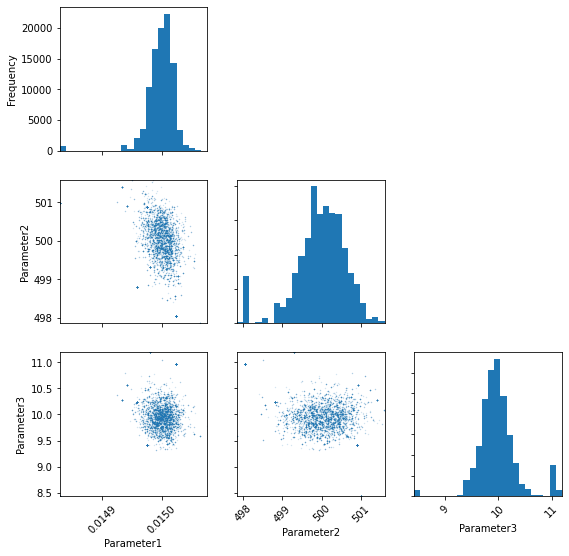

In [3]:
# Create mcmc routine with four chains
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.HaarioBardenetACMC)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# time start
start = time.time()

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# end time
end = time.time()
time_taken = end - start

# Discard warm up
chains = chains[:, 2000:, :]

# Look at distribution across all chains
pints.plot.pairwise(np.vstack(chains), kde=False)

# Show graphs
plt.show()

We can use [MCMCSummary](https://pints.readthedocs.io/en/latest/mcmc_samplers/summary_mcmc.html) to inspect the efficiency of the MCMC run.

In [4]:
results = pints.MCMCSummary(chains=chains, time=time_taken, parameter_names=["r", "k", "sigma"])
print(results)

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
r        0.01    0.00    0.01    0.01    0.02    0.02    0.02     1.02    254.46  100.29
k        499.95  0.66    498.05  499.65  500.02  500.40  501.00   1.07    273.65  107.85
sigma    9.98    0.36    9.42    9.79    9.95    10.11   10.97    1.09    229.38  90.40


Now, we create a log-transformation object and re-run the MCMC again to see if it makes any differences.

Running...
Done!


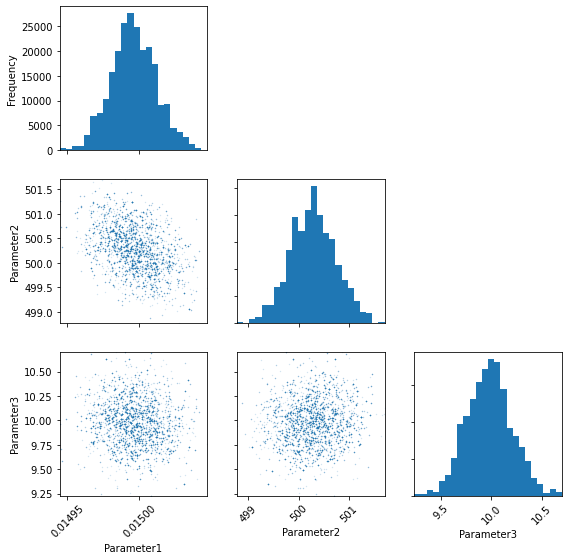

In [5]:
# Create parameter transformation
transform = pints.LogTransform()

# Create mcmc routine with four chains
mcmc = pints.MCMCController(log_posterior, 3, xs,
                            method=pints.HaarioBardenetACMC,
                            transform=transform)

# Add stopping criterion
mcmc.set_max_iterations(4000)

# Start adapting after 1000 iterations
mcmc.set_initial_phase_iterations(1000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# time start
start = time.time()

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

# end time
end = time.time()
time_taken = end - start

# Discard warm up
chains = chains[:, 2000:, :]

# Look at distribution across all chains
pints.plot.pairwise(np.vstack(chains), kde=False)

# Show graphs
plt.show()

The MCMC samples in the above plot looks very similar to the one without parameter transformation, which is good, so the transformation did not mess up anything. Now we check the efficiency again.

In [6]:
results = pints.MCMCSummary(chains=chains, time=time_taken, parameter_names=["r", "k", "sigma"])
print(results)

param    mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  ------  ------  ------  -------  ------  ------  --------------
r        0.01    0.00    0.01    0.01    0.01    0.02    0.02     1.00    392.39  148.01
k        500.28  0.45    499.38  499.97  500.28  500.59  501.18   1.01    434.40  163.85
sigma    9.98    0.23    9.54    9.82    9.98    10.12   10.43    1.01    444.83  167.79


With the log-transformation on the parameters, even we use the same data and the same initial positions for the MCMC runs, it outperforms the one without transformation in this example, showing the importance of the transformation.